# **COVID-19**

In [558]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

# **Data Acquisition**

In [1274]:
data = pd.read_csv("owid-covid-data.csv")

# **Exploratory Data Analysis**

In [1275]:
import missingno as msno
import plotly.express as px

## **Visualizing Null Data**

<AxesSubplot:>

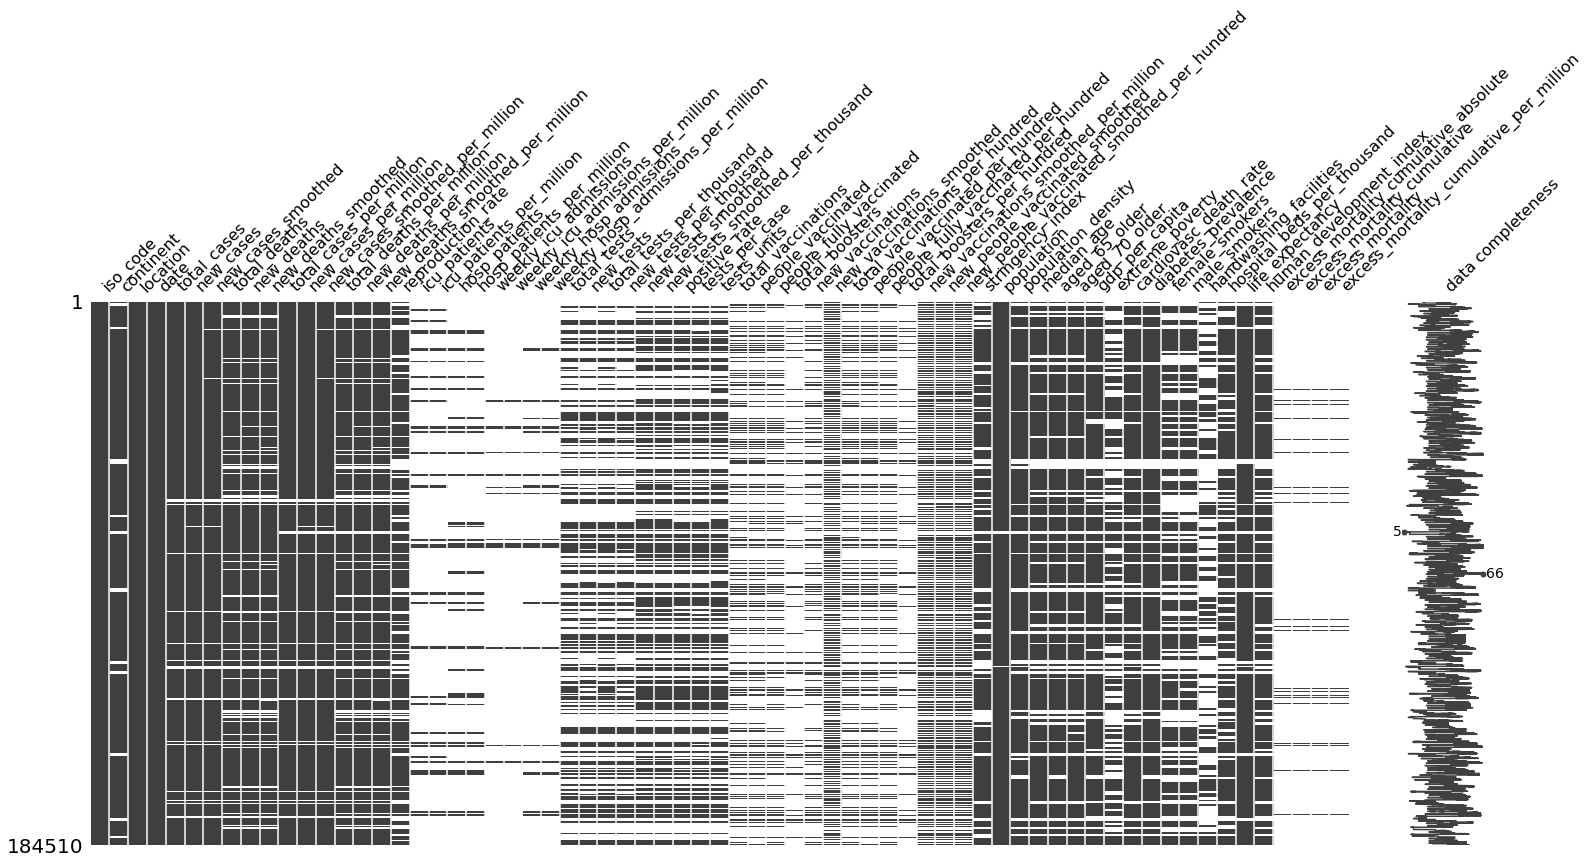

In [1276]:
msno.matrix(data, labels = True)

Transform dataframe for making plots

In [1277]:
all_df_eda = pd.DataFrame()
country_list =['World', "Indonesia", "Vietnam", "Thailand", "Philippines", "Singapore", "Malaysia", "Myanmar", "Laos", "Cambodia", "Brunei", "Timor"]
for i in country_list:
    all_df_eda = pd.concat([all_df_eda, data[data['location'].str.contains(i, na=False)]])

In [1278]:
all_df_eda["date"] = pd.to_datetime(all_df_eda["date"])

**New Cases and Total Cases Exploration**

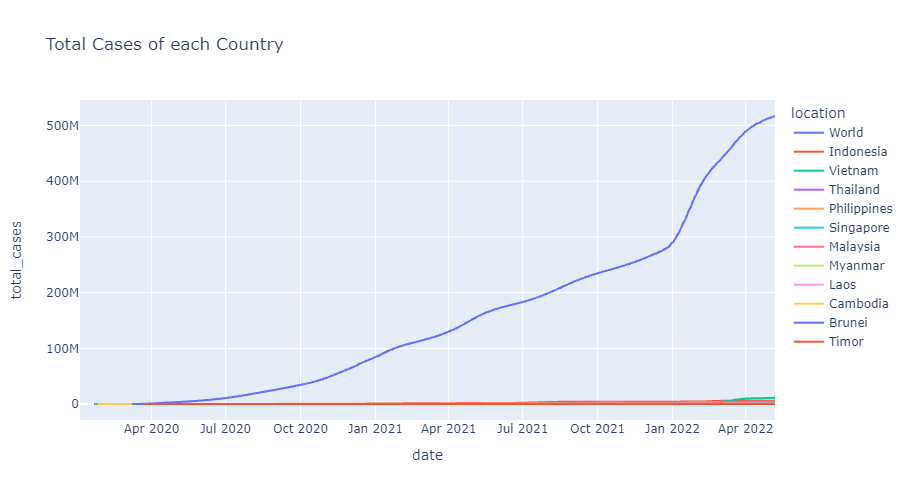

In [1279]:
fig = px.line(all_df_eda, x="date", y="total_cases", color='location', height=500, title = "Total Cases of each Country")
fig.show()

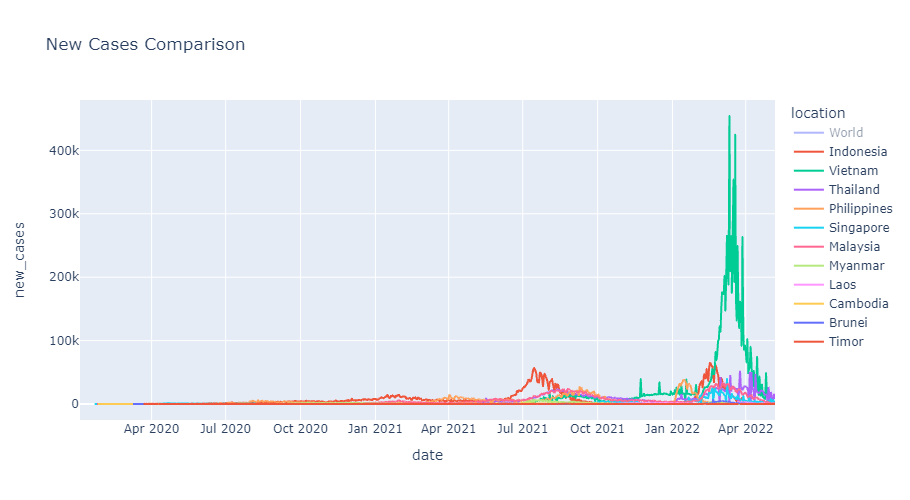

In [1280]:
fig = px.line(all_df_eda, x="date", y="new_cases", color='location', height=500, title = "New Cases Comparison")
fig.show()

# **Data Preprocessing**

In [1281]:
import sklearn.preprocessing as preprocessing
from statsmodels.tsa.stattools import adfuller

**Store all subset data in the dictionary**

In [1282]:
all_df = {}
country_list =['World', "Indonesia", "Vietnam", "Thailand", "Philippines", "Singapore", "Malaysia", "Myanmar", "Laos", "Cambodia", "Brunei", "Timor"]
for i in country_list:
    all_df[i] = data[data['location'].str.contains(i, na=False)]

In [1283]:
def preprocess_date(df):
    df["date"] = pd.to_datetime(df["date"])
    return df

In [1383]:
# one preprocess functino for date transform
def preprocess(df):
    # set date as a index
    df = preprocess_date(df)
    df = df.dropna(axis="columns", thresh = df["iso_code"].count() * 0.7)
    df = df.set_index("date").interpolate(method='linear', limit_direction='forward', axis=0)
    correlation = abs(df.corr()["total_cases"])
    
    # correlation feature selection
    if df["location"].unique()[0] != "Timor":
        df = df[correlation[correlation > 0.6].index]
    else:
        df = df[correlation[correlation > 0.1].index]

    df = df.select_dtypes("float")
    
    correlation = abs(df.corr()["total_cases"])
    
    # lag feature 
    for j in range(7):
        df[f"totalcases_{j}"] = df["total_cases"].shift(j)

    # dropna causes from lag
    df = df.dropna()
    
    return df

In [1285]:
df = preprocess(all_df["World"])
clear_output()

In [1287]:
scaler = preprocessing.StandardScaler()

In [1384]:
df_use = df[:pd.to_datetime("2022-05-7", dayfirst=True)]

all_for_test = df_use
train_df = df_use[:int(len(df_use) * 0.95)]
test_df = df_use[int(len(df_use) * 0.95):]

In [1385]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 789 entries, 2020-01-28 to 2022-03-26
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   total_cases                     789 non-null    float64
 1   new_cases                       789 non-null    float64
 2   new_cases_smoothed              789 non-null    float64
 3   total_deaths                    789 non-null    float64
 4   total_cases_per_million         789 non-null    float64
 5   new_cases_per_million           789 non-null    float64
 6   new_cases_smoothed_per_million  789 non-null    float64
 7   total_deaths_per_million        789 non-null    float64
 8   totalcases_0                    789 non-null    float64
 9   totalcases_1                    789 non-null    float64
 10  totalcases_2                    789 non-null    float64
 11  totalcases_3                    789 non-null    float64
 12  totalcases_4     

Scale y for easy explore error

In [1290]:
train_df["total_cases"] = scaler.fit_transform(train_df[["total_cases"]])
test_df["total_cases"] = scaler.transform(test_df[["total_cases"]])
clear_output()

In [1387]:
# preprocessing function for get only one prediction
def get_X_lstm(data, scaler):
    """Return model design matrix X"""
    data = data.drop(columns = ["total_cases"])
    data = scaler.transform(data)
    data = data.reshape(1, 7, data.shape[1])
    return data

In [1388]:
def lstm_preprocess(df, seq_size, scaler, istrainset = False):
    if istrainset:
        X_temp = scaler.fit_transform(df.drop(columns = ["total_cases"]))
    else:
        X_temp = scaler.transform(df.drop(columns = ["total_cases"]))
    y_temp = df["total_cases"]
    
    day = pd.Timedelta(days = seq_size)

    x = []
    y = []
    # to sequence function
    for i in range(len(df) - (seq_size + 1 + 7)):
        window = X_temp[i:(i+ seq_size)]
        y_index = i + seq_size
        after_window = y_temp[y_index + 1: y_index + 7 + 1]
        x.append(window)
        y.append(after_window)
    x = np.array(x)
    y = np.array(y)

    return x, y

In [1389]:
#standard preprocessor for all features
x_scaler = preprocessing.StandardScaler()

In [1390]:
X_train_lstm, y_train_lstm = lstm_preprocess(train_df, 7, x_scaler, True)
X_test_lstm, y_test_lstm = lstm_preprocess(test_df, 7, x_scaler, False)

Create all data sample for all prediction

In [1391]:
x_all_scaler = preprocessing.StandardScaler()

In [1392]:
X_all_lstm, y_all_lstm = lstm_preprocess(train_df, 7, x_all_scaler, True)

In [1351]:
y_test_lstm[0]

array([2.7994535 , 2.8101768 , 2.82165188, 2.83124949, 2.84066769,
       2.84676082, 2.85124792])

**Specify X for testing period and y for error measurement**

In [1352]:
X_topred = get_X_lstm(df[pd.to_datetime("2022-05-07", dayfirst=True) - pd.Timedelta(days=6):pd.to_datetime("2022-05-07", dayfirst=True)], x_scaler)
y_totest = df[pd.to_datetime("2022-04-17", dayfirst=True):pd.to_datetime("2022-04-23", dayfirst=True)]["total_cases"].values

In [1353]:
y_totest

array([5.04631226e+08, 5.05109012e+08, 5.06094796e+08, 5.07059109e+08,
       5.07970124e+08, 5.08769477e+08, 5.09286465e+08])

# **Modeling**

In [1354]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, GRU, RNN, Input
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import tensorflow_addons as tfa
from keras_radam import RAdam
import keras.backend as K
import keras_tuner as kt

from sklearn.metrics import mean_squared_error
clear_output()

## **LSTM**

Using Ranger Optimizer

In [1355]:
def mish(x):
    return tfa.activations.mish(x)

Using Mish Activation function

In [1356]:
radam = tfa.optimizers.RectifiedAdam()
ranger = tfa.optimizers.Lookahead(radam, sync_period=7, slow_step_size=0.7)

**Sample Manual Built LSTM RNN Model**

In [1314]:
model = Sequential()
model.add(Input(shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])))

model.add(LSTM(320, activation = mish))
model.add(Dropout(0.04))

model.add(Dense(7))

opt = ranger

model.compile(loss = tf.keras.losses.MeanSquaredError(),
             optimizer = opt,
             metrics = [tf.keras.losses.MeanSquaredError(name = "mse")])
model.summary()

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 320)               428800    
                                                                 
 dropout_32 (Dropout)        (None, 320)               0         
                                                                 
 dense_54 (Dense)            (None, 7)                 2247      
                                                                 
Total params: 431,047
Trainable params: 431,047
Non-trainable params: 0
_________________________________________________________________


In [1315]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)
history = model.fit(
                    X_train_lstm,
                    y_train_lstm,
                    epochs = 200,
                    validation_split = 0.05,
                    callbacks = [earlystop],
                    verbose = 1
                   )

Epoch 1/200
23/23 [==============================] - 7s 71ms/step - loss: 0.6719 - mse: 0.6721 - val_loss: 4.9671 - val_mse: 5.3252
Epoch 2/200
23/23 [==============================] - 1s 42ms/step - loss: 0.5416 - mse: 0.5415 - val_loss: 3.4618 - val_mse: 3.7524
Epoch 3/200
23/23 [==============================] - 1s 41ms/step - loss: 0.3268 - mse: 0.3266 - val_loss: 0.8462 - val_mse: 0.9610
Epoch 4/200
23/23 [==============================] - 1s 40ms/step - loss: 0.1079 - mse: 0.1079 - val_loss: 0.3262 - val_mse: 0.3630
Epoch 5/200
23/23 [==============================] - 1s 55ms/step - loss: 0.0344 - mse: 0.0343 - val_loss: 1.0671 - val_mse: 1.4554
Epoch 6/200
23/23 [==============================] - 1s 46ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 1.2607 - val_mse: 1.7674
Epoch 7/200
23/23 [==============================] - 1s 42ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.6862 - val_mse: 0.9483
Epoch 8/200
23/23 [==============================] - 1s 42ms/step - loss: 0.

### **Single Architecture Tuning**

In [1357]:
def build_lstm(hp):
    model = Sequential()
    model.add(Input(shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])))

    n_layer = hp.Choice("num_layer", [0, 1])
    return_s = False
    if n_layer == 1:
        return_s = True
    model.add(LSTM(units=hp.Int('units_0', min_value=32, max_value=512, step=32), return_sequences = return_s, activation = mish))
    model.add(Dropout(hp.Float("dropout", 0, 0.2)))

    if n_layer == 1:
        model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation = mish))
        model.add(Dropout(hp.Float("dropout", 0, 0.2)))

    model.add(Dense(7))

    model.compile(loss = "mse",
             optimizer = ranger,
             metrics = ['mse'])

    return model

In [851]:
bayesian_opt = kt.BayesianOptimization(build_lstm,
                            objective="val_loss",
                            max_trials = 50,
                            project_name = "lstm_regression"
                           )

Reloading Oracle from existing project .\lstm_regression\oracle.json
Reloading Tuner from .\lstm_regression\tuner0.json


In [852]:
bayesian_opt.search(X_train_lstm, y_train_lstm, validation_split = 0.05, verbose = 1, epochs = 200, 
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)])

Oracle triggered exit


get best model and train again

In [853]:
# Get the top 2 hyperparameters.
best_hps = bayesian_opt.get_best_hyperparameters(1)

In [854]:
# Build the model with the best hp.
model = build_lstm(best_hps[0])
# Fit with the entire dataset.
history = model.fit(x=X_train_lstm, y=y_train_lstm, epochs=200, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss',  patience=10)])

Epoch 1/200
24/24 [==============================] - 6s 39ms/step - loss: 0.1249 - mse: 0.1249
Epoch 2/200
24/24 [==============================] - 1s 39ms/step - loss: 0.0070 - mse: 0.0070
Epoch 3/200
24/24 [==============================] - 1s 40ms/step - loss: 0.0025 - mse: 0.0025
Epoch 4/200
24/24 [==============================] - 1s 40ms/step - loss: 0.0016 - mse: 0.0016
Epoch 5/200
24/24 [==============================] - 1s 43ms/step - loss: 0.0015 - mse: 0.0015
Epoch 6/200
24/24 [==============================] - 1s 41ms/step - loss: 0.0013 - mse: 0.0013
Epoch 7/200
24/24 [==============================] - 1s 40ms/step - loss: 0.0011 - mse: 0.0011
Epoch 8/200
24/24 [==============================] - 1s 42ms/step - loss: 8.8036e-04 - mse: 8.8036e-04
Epoch 9/200
24/24 [==============================] - 1s 40ms/step - loss: 0.0017 - mse: 0.0017
Epoch 10/200
24/24 [==============================] - 1s 41ms/step - loss: 0.0011 - mse: 0.0011  
Epoch 11/200
24/24 [===================

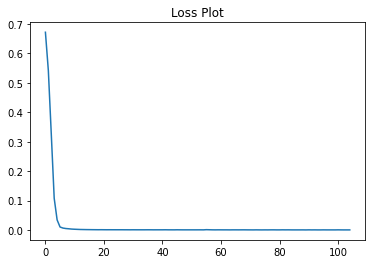

In [1358]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title("Loss Plot")
plt.show()

**Error Measurements**

In [1359]:
pred_test = model.predict(X_test_lstm)
pred_train = model.predict(X_train_lstm)

In [1360]:
print(f"Test set MSE: {model.evaluate(X_test_lstm, y_test_lstm)[0]}")

1/1 [==============================] - 0s 43ms/step - loss: 0.0055 - mse: 0.0055
Test set MSE: 0.005539171863347292


In [1361]:
pred_testtest = scaler.inverse_transform(model.predict(X_topred).flatten().reshape(-1, 1))
print(f"Test Period MSE: {mean_squared_error(y_totest, pred_testtest)}")

Test Period MSE: 34650063468654.715


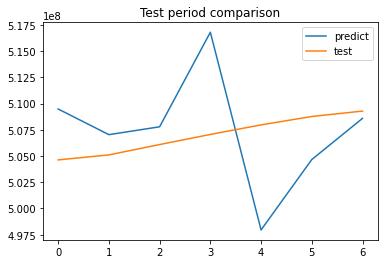

In [1362]:
plt.plot(pred_testtest, label = "predict")
plt.plot(y_totest, label = "test")
plt.title("Test period comparison")
plt.legend()
plt.show()

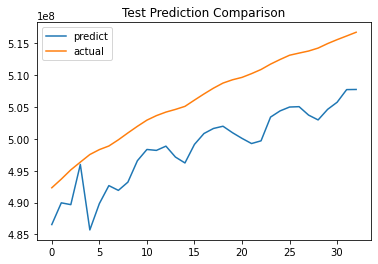

In [1363]:
y_true_train = []
y_true_train_pred = []
y_true_temp = []
y_pred_temp = []
for i in range(len(pred_train[:])):
    if i == 0:
        y_true_train_pred = list(pred_train[i].flatten())
        # y_pred_temp.append(pred_test[i].flatten())
        y_true_train = list(y_train_lstm[i].flatten())
    else:
        y_true_train.append(list(y_train_lstm[i].flatten())[-1])
        y_true_train_pred.append(list(pred_train[i].flatten())[-1])
for i in range(len(pred_test[:])):
    if i == 0:
        y_pred_temp = list(pred_test[i].flatten())
        # y_pred_temp.append(pred_test[i].flatten())
        y_true_temp = list(y_test_lstm[i].flatten())
    else:
        y_true_temp.append(list(y_test_lstm[i].flatten())[-1])
        y_pred_temp.append(list(pred_test[i].flatten())[-1])
# plt.plot(scaler.inverse_transform(y_true_train_pred), label = "predict")
# plt.plot(scaler.inverse_transform(y_true_train), label = "actual")
plt.plot(scaler.inverse_transform(y_pred_temp), label = "predict")
plt.plot(scaler.inverse_transform(y_true_temp), label = "actual")
    # plt.plot(np.exp(pred_test[i].flatten()), label = "predict")
    # plt.plot(np.exp(y_test_lstm[i].flatten()), label = "test")
    # mean_squared_error()
plt.legend()
plt.title("Test Prediction Comparison")
plt.show()

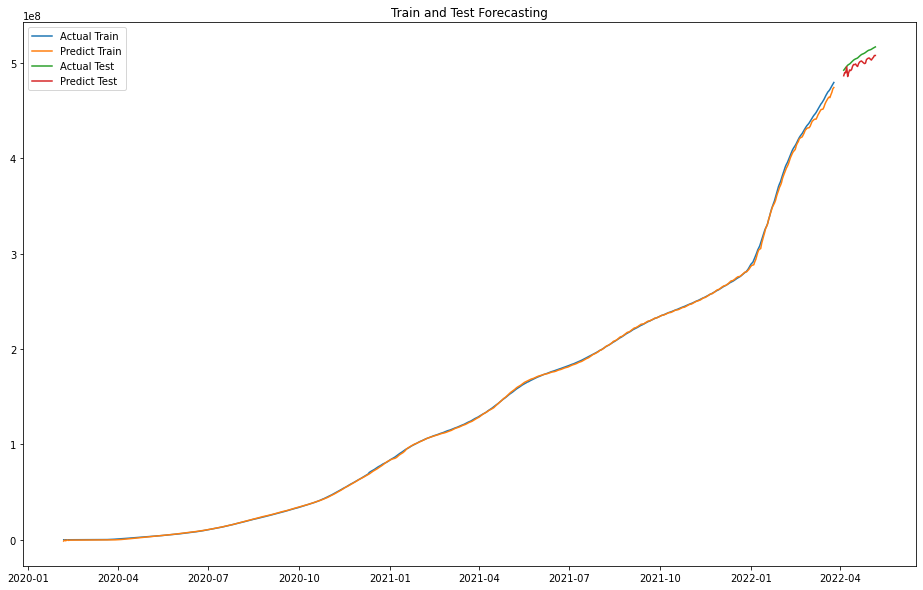

In [1364]:
plt.figure(figsize = (16, 10))
y_pred_temp = pd.Series(data = scaler.inverse_transform(y_pred_temp), index = test_df.index[9:])
y_true_temp = pd.Series(data = scaler.inverse_transform(y_true_temp), index = test_df.index[9:])
y_true_train_pred = pd.Series(data = scaler.inverse_transform(y_true_train_pred), index = all_for_test.index[9:-test_df.shape[0]])
y_true_train = pd.Series(data = scaler.inverse_transform(y_true_train), index = all_for_test.index[9:-test_df.shape[0]])
plt.plot(y_true_train, label = "Actual Train")
plt.plot(y_true_train_pred, label = "Predict Train")
plt.plot(y_true_temp, label = "Actual Test")
plt.plot(y_pred_temp, label = "Predict Test")
plt.title("Train and Test Forecasting")
plt.legend()
plt.show()

### **Get Result**

In [1393]:
def all_model(df, only_result_mode = False):
    """
        df: input dataframe dictionary
        only_result_mode: the function will train with all data provided and predict the submission period 
        (with the purpose of getting the most accurate submission prediction result)
    """
    result_lstm = {}
    all_train_err = {}
    all_test_err = {}
    test_err = {}
    for i in df:
        df_in = preprocess(all_df[i])
        # get y value for test period
        y_totest = df_in[pd.to_datetime("2022-05-07", dayfirst=True) - pd.Timedelta(days=6):pd.to_datetime("2022-05-07", dayfirst=True)]["total_cases"].values
        # seperate to train and test df with ratio 95:5
        df_in = df_in[:pd.to_datetime("2022-05-07", dayfirst=True)]
        if only_result_mode:
            train_index = int(len(df_in) * 1)
        else:
            train_index = int(len(df_in) * 0.95)
        train_df_in = df_in[:train_index]
        test_df_in = df_in[int(len(df_in) * 0.95):]
        y_scaler = preprocessing.StandardScaler()
        train_df_in["total_cases"] = y_scaler.fit_transform(train_df_in[["total_cases"]])
        test_df_in["total_cases"] = y_scaler.transform(test_df_in[["total_cases"]])

        
        xin_scaler = preprocessing.StandardScaler()
        X_train_lstm_in, y_train_lstm_in = lstm_preprocess(train_df_in, 7, xin_scaler, True)
        X_test_lstm_in, y_test_lstm_in = lstm_preprocess(test_df_in, 7, xin_scaler, False)
        X_topred_in = get_X_lstm(df_in[pd.to_datetime("2022-05-07", dayfirst=True) - pd.Timedelta(days=6):pd.to_datetime("2022-05-07", dayfirst=True)], xin_scaler)

        clear_output()
        print(f"currently processing {i}")

        def build_lstm(hp):
            model = Sequential()
            model.add(Input(shape = (X_train_lstm_in.shape[1], X_train_lstm_in.shape[2])))

            n_layer = hp.Choice("num_layer", [0, 1])
            return_s = False
            if n_layer == 1:
                return_s = True
            model.add(LSTM(units=hp.Int('units_0', min_value=32, max_value=512, step=32), return_sequences = return_s, activation = mish))
            model.add(Dropout(hp.Float("dropout", 0, 0.2)))

            if n_layer == 1:
                model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation = mish))
                model.add(Dropout(hp.Float("dropout", 0, 0.2)))

            model.add(Dense(7))

            model.compile(loss = "mse",
                     optimizer = ranger,
                     metrics = ['mse'])

            return model
        
        bayesian_opt = kt.BayesianOptimization(build_lstm,
                            objective="val_loss",
                            max_trials = 10,
                            project_name = f"lstm_tuning_all/lstm_{i}"
                           )
        
        bayesian_opt.search(X_train_lstm_in, y_train_lstm_in, validation_split = 0.05, verbose = 1, epochs = 200, 
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)])
        best_hps = bayesian_opt.get_best_hyperparameters(1)
        model = build_lstm(best_hps[0])
    
        # Fit with the entire dataset.
        history = model.fit(x=X_train_lstm_in, y=y_train_lstm_in, epochs=200, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss',  patience=10)])
        
        # save model for later
        model.save(f"saved_model_16/lstm_{i}")

        # append all train and test error
        all_train_err[i] = model.evaluate(X_train_lstm_in, y_train_lstm_in)[0]
        all_test_err[i] = model.evaluate(X_test_lstm_in, y_test_lstm_in)[0]

        # append current prediction result
        result_current = model.predict(X_topred_in)
        result_lstm[i] = y_scaler.inverse_transform(result_current.flatten().reshape(-1, 1))
        
        # find error of 7 days sample test period
        test_err[i] = mean_squared_error(y_totest, result_lstm[i])
        
        
        clear_output()
    
    if only_result_mode:
        # only_result_mode only return result_lstm
        return {
            'result': result_lstm,
            '7test_err': test_err
        }
    else:
        return {
            'result': result_lstm,
            'train_err': all_train_err,
            'test_err': all_test_err,
            '7test_err': test_err
        }

**For tuning all models**

In [1049]:
result_lstm = all_model(all_df)

**For training all data and get 7 days result (tuning required for saving model history into the keras tuner oracle)**

In [1051]:
result_lstm_7 = all_model(all_df, True)

In [1052]:
result_lstm["7test_err"]

{'World': 21723235916106.145,
 'Indonesia': 951448642539.1428,
 'Vietnam': 9465402952964.285,
 'Thailand': 196857131688.57144,
 'Philippines': 11101531804.8125,
 'Singapore': 52869268522.20927,
 'Malaysia': 579734632650.5,
 'Myanmar': 367048651.05245537,
 'Laos': 2160472674.4905133,
 'Cambodia': 2938204.5973772323,
 'Brunei': 1780753417.0389578,
 'Timor': 11836.19197354998}

In [1098]:
result_lstm_7["7test_err"]

{'World': 1451252298917.5715,
 'Indonesia': 3393034757.392857,
 'Vietnam': 63172887924.42857,
 'Thailand': 20706022556.69643,
 'Philippines': 1639970216.4285715,
 'Singapore': 89919097.52455357,
 'Malaysia': 12823253304.535715,
 'Myanmar': 22674735.022879463,
 'Laos': 96845537.86917551,
 'Cambodia': 12869.252825055804,
 'Brunei': 16553811.850132534,
 'Timor': 1723.3725324358259}

**Get result into the dataframe**

In [1130]:
result_lstm_df = pd.DataFrame()

In [1131]:
for i in result_lstm_7["result"]:
    temp = pd.DataFrame(result_lstm_7["result"][i], columns=["total_cases"])
    temp["date"] = pd.date_range("2022-04-17", "2022-04-23")
    temp["location"] = i
    result_lstm_df = pd.concat([result_lstm_df, temp], ignore_index=True)

In [1132]:
result_lstm_df = result_lstm_df[["location", "date", "total_cases"]]

In [1133]:
result_lstm_df.to_csv("regression_result/Regression_62070242_62070278_62070285_12121.csv")

In [1134]:
result_lstm_df

,location,date,total_cases
0,World,2022-04-17,5.052789e+08
1,World,2022-04-18,5.063972e+08
2,World,2022-04-19,5.066589e+08
3,World,2022-04-20,5.074810e+08
4,World,2022-04-21,5.095532e+08
...,...,...,...
79,Timor,2022-04-19,2.286179e+04
80,Timor,2022-04-20,2.288761e+04
81,Timor,2022-04-21,2.287315e+04
82,Timor,2022-04-22,2.292913e+04


## **GRU**

**Sample Manual Built LSTM GRU Model**

In [1374]:
model_gru = Sequential()
model_gru.add(Input(shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])))

# model_gru.add(GRU(256, activation = mish, return_sequences = True))
model_gru.add(GRU(256, activation = mish))

model_gru.add(Dense(7))

opt = ranger
# opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)

model_gru.compile(loss = tf.keras.losses.MeanSquaredError(),
             optimizer = ranger,
             metrics = [tf.keras.losses.MeanSquaredError(name = "mse")])
model_gru.summary()

Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_103 (GRU)               (None, 256)               208896    
                                                                 
 dense_83 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 210,695
Trainable params: 210,695
Non-trainable params: 0
_________________________________________________________________


___
**GRU Use the same preprocess procedure as LSTM as two of it is RNN**
___

In [1375]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)
history = model_gru.fit(
                    X_train_lstm,
                    y_train_lstm,
                    epochs = 200,
                    # validation_split = 0.05,
                    callbacks = [earlystop],
                    verbose = 1
                   )

Epoch 1/200
25/25 [==============================] - 3s 18ms/step - loss: 0.9610 - mse: 0.9451
Epoch 2/200
25/25 [==============================] - 0s 16ms/step - loss: 0.6420 - mse: 0.6313
Epoch 3/200
25/25 [==============================] - 0s 17ms/step - loss: 0.2508 - mse: 0.2459
Epoch 4/200
25/25 [==============================] - 0s 17ms/step - loss: 0.0402 - mse: 0.0391
Epoch 5/200
25/25 [==============================] - 0s 17ms/step - loss: 0.0072 - mse: 0.0071
Epoch 6/200
25/25 [==============================] - 0s 18ms/step - loss: 0.0021 - mse: 0.0021
Epoch 7/200
25/25 [==============================] - 0s 19ms/step - loss: 8.9856e-04 - mse: 9.0131e-04
Epoch 8/200
25/25 [==============================] - 0s 18ms/step - loss: 6.2124e-04 - mse: 6.2212e-04
Epoch 9/200
25/25 [==============================] - 0s 18ms/step - loss: 5.0714e-04 - mse: 4.9711e-04
Epoch 10/200
25/25 [==============================] - 0s 17ms/step - loss: 4.2697e-04 - mse: 4.2447e-04
Epoch 11/200
25/2

### **Single Architecture Tuning**

In [954]:
def build_gru(hp):
    model = Sequential()
    model.add(Input(shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])))

    n_layer = hp.Choice("num_layer", [0, 1])
    return_s = False
    if n_layer == 1:
        return_s = True
    model.add(GRU(units=hp.Int('units_0', min_value=32, max_value=512, step=32), return_sequences = return_s, activation = mish))
    model.add(Dropout(hp.Float("dropout", 0, 0.2)))

    if n_layer == 1:
        model.add(GRU(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation = mish))
        model.add(Dropout(hp.Float("dropout", 0, 0.2)))

    model.add(Dense(7))

    model.compile(loss = "mse",
             optimizer = ranger,
             metrics = ['mse'])

    return model

In [956]:
bayesian_opt_gru = kt.BayesianOptimization(build_gru,
                            objective="val_loss",
                            max_trials = 5,
                            project_name = "gru_regression"
                           )

In [957]:
bayesian_opt_gru.search(X_train_lstm, y_train_lstm, validation_split = 0.05, verbose = 1, epochs = 200, 
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)])

Oracle triggered exit


Trial 5 Complete [00h 00m 24s]
val_loss: 0.023210927844047546

Best val_loss So Far: 0.0027807950973510742
Total elapsed time: 00h 10m 30s


get best model and train again

In [960]:
# Get the top 2 hyperparameters.
best_hps_gru = bayesian_opt.get_best_hyperparameters(1)

In [961]:
# Build the model with the best hp.
model_gru = build_gru(best_hps_gru[0])
# Fit with the entire dataset.
history = model_gru.fit(x=X_train_lstm, y=y_train_lstm, epochs=200, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss',  patience=10)])

Epoch 1/200
24/24 [==============================] - 16s 78ms/step - loss: 0.1235 - mse: 0.1235
Epoch 2/200
24/24 [==============================] - 2s 66ms/step - loss: 0.0050 - mse: 0.0050
Epoch 3/200
24/24 [==============================] - 2s 71ms/step - loss: 0.0026 - mse: 0.0026
Epoch 4/200
24/24 [==============================] - 2s 70ms/step - loss: 0.0024 - mse: 0.0024
Epoch 5/200
24/24 [==============================] - 2s 70ms/step - loss: 0.0023 - mse: 0.0023
Epoch 6/200
24/24 [==============================] - 2s 78ms/step - loss: 0.0017 - mse: 0.0017
Epoch 7/200
24/24 [==============================] - 2s 72ms/step - loss: 0.0017 - mse: 0.0017
Epoch 8/200
24/24 [==============================] - 2s 72ms/step - loss: 0.0018 - mse: 0.0018
Epoch 9/200
24/24 [==============================] - 2s 71ms/step - loss: 0.0018 - mse: 0.0018
Epoch 10/200
24/24 [==============================] - 2s 72ms/step - loss: 0.0014 - mse: 0.0014
Epoch 11/200
24/24 [============================

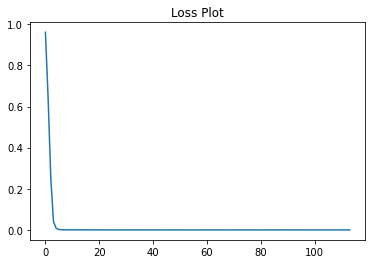

In [1376]:
plt.plot(history.history['loss'])
plt.title("Loss Plot")
plt.show()

In [1377]:
pred_test_gru = model_gru.predict(X_test_lstm)
pred_train_gru = model_gru.predict(X_train_lstm)

In [1378]:
print(f"Test set MSE: {model_gru.evaluate(X_test_lstm, y_test_lstm)[0]}")

1/1 [==============================] - 0s 291ms/step - loss: 5.4375e-04 - mse: 5.4375e-04
Test set MSE: 0.0005437536747194827


In [1379]:
pred_testtest_gru = scaler.inverse_transform(model_gru.predict(X_topred).flatten().reshape(-1, 1))
print(f"Test Period MSE: {mean_squared_error(y_totest, pred_testtest_gru)}")

Test Period MSE: 127487638848247.86


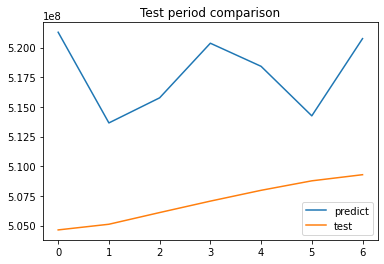

In [1380]:
plt.plot(pred_testtest_gru, label = "predict")
plt.plot(y_totest, label = "test")
plt.title("Test period comparison")
plt.legend()
plt.show()

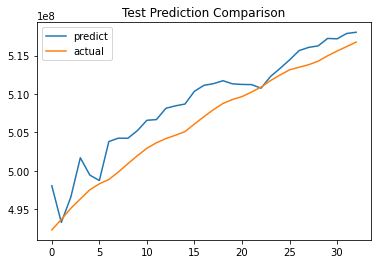

In [1381]:
y_true_train = []
y_true_train_pred = []
y_true_temp = []
y_pred_temp = []
for i in range(len(pred_train_gru[:])):
    if i == 0:
        y_true_train_pred = list(pred_train_gru[i].flatten())
        # y_pred_temp.append(pred_test[i].flatten())
        y_true_train = list(y_train_lstm[i].flatten())
    else:
        y_true_train.append(list(y_train_lstm[i].flatten())[-1])
        y_true_train_pred.append(list(pred_train_gru[i].flatten())[-1])
for i in range(len(pred_test_gru[:])):
    if i == 0:
        y_pred_temp = list(pred_test_gru[i].flatten())
        # y_pred_temp.append(pred_test[i].flatten())
        y_true_temp = list(y_test_lstm[i].flatten())
    else:
        y_true_temp.append(list(y_test_lstm[i].flatten())[-1])
        y_pred_temp.append(list(pred_test_gru[i].flatten())[-1])
plt.plot(scaler.inverse_transform(y_pred_temp), label = "predict")
plt.plot(scaler.inverse_transform(y_true_temp), label = "actual")
plt.legend()
plt.title("Test Prediction Comparison")
plt.show()

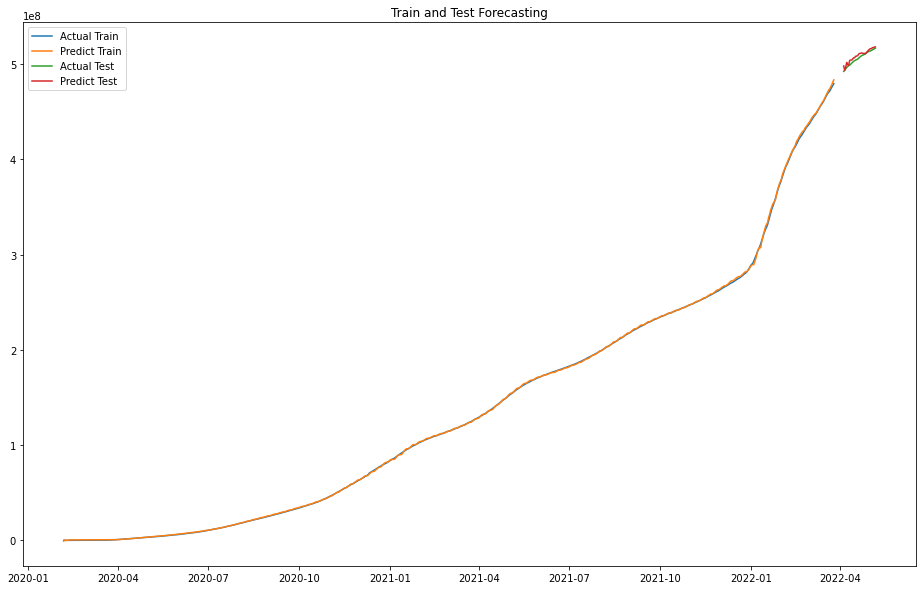

In [1382]:
plt.figure(figsize = (16, 10))
y_pred_temp = pd.Series(data = scaler.inverse_transform(y_pred_temp), index = test_df.index[9:])
y_true_temp = pd.Series(data = scaler.inverse_transform(y_true_temp), index = test_df.index[9:])
y_true_train_pred = pd.Series(data = scaler.inverse_transform(y_true_train_pred), index = all_for_test.index[9:-test_df.shape[0]])
y_true_train = pd.Series(data = scaler.inverse_transform(y_true_train), index = all_for_test.index[9:-test_df.shape[0]])
plt.plot(y_true_train, label = "Actual Train")
plt.plot(y_true_train_pred, label = "Predict Train")
plt.plot(y_true_temp, label = "Actual Test")
plt.plot(y_pred_temp, label = "Predict Test")
plt.title("Train and Test Forecasting")
plt.legend()
plt.show()

### **Get Result**

In [1341]:
def all_model_gru(df, only_result_mode = False):
    """
        df: input dataframe dictionary
        only_result_mode: the function will train with all data provided and predict the submission period 
        (with the purpose of getting the most accurate submission prediction result)
    """
    result_lstm = {}
    all_train_err = {}
    all_test_err = {}
    test_err = {}
    for i in df:
        df_in = preprocess(all_df[i])
        # get y value for test period
        y_totest = df_in[pd.to_datetime("2022-05-07", dayfirst=True) - pd.Timedelta(days=6):pd.to_datetime("2022-05-07", dayfirst=True)]["total_cases"].values
        # seperate to train and test df with ratio 95:5
        df_in = df_in[:pd.to_datetime("2022-05-07", dayfirst=True)]
        if only_result_mode:
            train_index = int(len(df_in) * 1)
        else:
            train_index = int(len(df_in) * 0.95)
        train_df_in = df_in[:train_index]
        test_df_in = df_in[int(len(df_in) * 0.95):]
        y_scaler = preprocessing.StandardScaler()
        train_df_in["total_cases"] = y_scaler.fit_transform(train_df_in[["total_cases"]])
        test_df_in["total_cases"] = y_scaler.transform(test_df_in[["total_cases"]])

        xin_scaler = preprocessing.StandardScaler()
        X_train_lstm_in, y_train_lstm_in = lstm_preprocess(train_df_in, 7, xin_scaler, True)
        X_test_lstm_in, y_test_lstm_in = lstm_preprocess(test_df_in, 7, xin_scaler, False)
        X_topred_in = get_X_lstm(df_in[pd.to_datetime("2022-05-07", dayfirst=True) - pd.Timedelta(days=6):pd.to_datetime("2022-05-07", dayfirst=True)], xin_scaler)

        clear_output()
        print(f"currently processing {i}")

        def build_lstm(hp):
            model = Sequential()
            model.add(Input(shape = (X_train_lstm_in.shape[1], X_train_lstm_in.shape[2])))

            n_layer = hp.Choice("num_layer", [0, 1])
            return_s = False
            if n_layer == 1:
                return_s = True
            model.add(GRU(units=hp.Int('units_0', min_value=32, max_value=512, step=32), return_sequences = return_s, activation = mish))
            model.add(Dropout(hp.Float("dropout", 0, 0.2)))

            if n_layer == 1:
                model.add(GRU(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation = mish))
                model.add(Dropout(hp.Float("dropout", 0, 0.2)))

            model.add(Dense(7))

            model.compile(loss = "mse",
                     optimizer = ranger,
                     metrics = ['mse'])

            return model
        
        bayesian_opt = kt.BayesianOptimization(build_lstm,
                            objective="val_loss",
                            max_trials = 10,
                            project_name = f"gru_tuning_all/gru_{i}"
                           )

        bayesian_opt.search(X_train_lstm_in, y_train_lstm_in, validation_split = 0.05, verbose = 1, epochs = 200, 
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)])
        best_hps = bayesian_opt.get_best_hyperparameters(1)
        model = build_lstm(best_hps[0])

        # Fit with the entire dataset.
        history = model.fit(x=X_train_lstm_in, y=y_train_lstm_in, epochs=200, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss',  patience=10)])
        
        # append all train and test error
        all_train_err[i] = model.evaluate(X_train_lstm_in, y_train_lstm_in)[0]
        all_test_err[i] = model.evaluate(X_test_lstm_in, y_test_lstm_in)[0]

        # append current prediction result
        result_current = model.predict(X_topred_in)
        result_lstm[i] = y_scaler.inverse_transform(result_current.flatten().reshape(-1, 1))
        
        # find error of 7 days sample test period
        test_err[i] = mean_squared_error(y_totest, result_lstm[i])
        
        
        clear_output()
    
    if only_result_mode:
        # only_result_mode only return result_lstm
        return {
            'result': result_lstm,
            '7test_err': test_err
        }
    else:
        return {
            'result': result_lstm,
            'train_err': all_train_err,
            'test_err': all_test_err,
            '7test_err': test_err
        }

**For all models tuning and saving tuning history to oracle**

In [1061]:
result_gru = all_model_gru(all_df)

**For 7 days testing period result**

In [1064]:
result_gru_7 = all_model_gru(all_df, True)

___


**Get new prediction result of 9 to 15**

In [1324]:
result_gru_7_915 = all_model_gru(all_df, True)

In [1326]:
result_gru_7_915["result"]

{'World': array([[5.1596957e+08],
        [5.1698560e+08],
        [5.1773693e+08],
        [5.1911981e+08],
        [5.2039472e+08],
        [5.2088787e+08],
        [5.2115565e+08]], dtype=float32),
 'Indonesia': array([[6071541. ],
        [6080814. ],
        [6059757.5],
        [6047185. ],
        [6061166.5],
        [6059679.5],
        [6061559.5]], dtype=float32),
 'Vietnam': array([[10409098.],
        [10527467.],
        [10455969.],
        [10407180.],
        [10577178.],
        [10636197.],
        [10595557.]], dtype=float32),
 'Thailand': array([[4328628.5],
        [4329103.5],
        [4347595. ],
        [4384768. ],
        [4371143. ],
        [4377198.5],
        [4358748.5]], dtype=float32),
 'Philippines': array([[3717944. ],
        [3708742. ],
        [3715237.8],
        [3723579.2],
        [3721656. ],
        [3720761.8],
        [3727751. ]], dtype=float32),
 'Singapore': array([[1198562.9],
        [1218025.4],
        [1183899.5],
        [1203278

___


**Get all prediction result of 9 to 15 to DataFrame**

In [1335]:
result_gru_df = pd.DataFrame()

In [1336]:
for i in result_gru_7_915["result"]:
    temp = pd.DataFrame(result_gru_7_915["result"][i], columns=["total_cases"])
    temp["date"] = pd.date_range("2022-05-09", "2022-05-15")
    temp["location"] = i
    result_gru_df = pd.concat([result_gru_df, temp], ignore_index=True)

In [1337]:
result_gru_df = result_gru_df[["location", "date", "total_cases"]]

In [1338]:
result_gru_df

,location,date,total_cases
0,World,2022-05-09,5.159696e+08
1,World,2022-05-10,5.169856e+08
2,World,2022-05-11,5.177369e+08
3,World,2022-05-12,5.191198e+08
4,World,2022-05-13,5.203947e+08
...,...,...,...
79,Timor,2022-05-11,2.292484e+04
80,Timor,2022-05-12,2.284307e+04
81,Timor,2022-05-13,2.290821e+04
82,Timor,2022-05-14,2.291744e+04


In [1339]:
result_gru_df.to_csv("regression_result/Regression_62070242_62070278_62070285.csv")

## **Evaluation**

### **5% Test Period Comparison**

In [1073]:
model_list = ['LSTM', 'GRU']
mse = [result_lstm["test_err"], result_gru["test_err"]]
model_todf = []
country = []
model_err = []
for i in range(len(model_list)):
    for j in mse[i]:
        country.append(j)
        model_err.append(mse[i][j])
        model_todf.append(model_list[i])

In [1074]:
test_err_df = pd.DataFrame({
    'Model': model_todf,
    'Country': country,
    'MSE': model_err
})

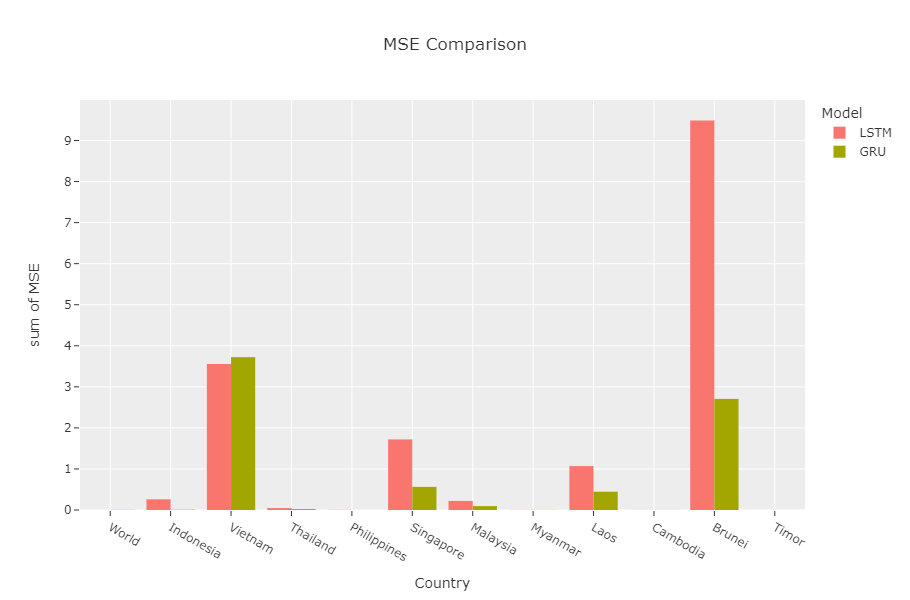

In [1340]:
fig = px.histogram(test_err_df, x="Country", y="MSE",
             color='Model', barmode='group', template = 'ggplot2',
             height=600, title = "MSE Comparison")
fig.show()

In [1092]:
print(test_err_df[test_err_df["Model"] == "LSTM"])
lstm_score = test_err_df[test_err_df["Model"] == "LSTM"]["MSE"].mean()
print(f"Average Score: {lstm_score}")

   Model      Country       MSE
0   LSTM        World  0.000413
1   LSTM    Indonesia  0.259973
2   LSTM      Vietnam  3.555850
3   LSTM     Thailand  0.046535
4   LSTM  Philippines  0.005252
5   LSTM    Singapore  1.718580
6   LSTM     Malaysia  0.220344
7   LSTM      Myanmar  0.004541
8   LSTM         Laos  1.069820
9   LSTM     Cambodia  0.001660
10  LSTM       Brunei  9.487145
11  LSTM        Timor  0.000284
Average Score: 1.3641998270832119


In [1093]:
print(test_err_df[test_err_df["Model"] == "GRU"])
lstm_score = test_err_df[test_err_df["Model"] == "GRU"]["MSE"].mean()
print(f"Average Score: {lstm_score}")

   Model      Country       MSE
12   GRU        World  0.006180
13   GRU    Indonesia  0.010791
14   GRU      Vietnam  3.721843
15   GRU     Thailand  0.022878
16   GRU  Philippines  0.000191
17   GRU    Singapore  0.563667
18   GRU     Malaysia  0.094532
19   GRU      Myanmar  0.004062
20   GRU         Laos  0.445338
21   GRU     Cambodia  0.002732
22   GRU       Brunei  2.705770
23   GRU        Timor  0.000726
Average Score: 0.6315591534318324
